# Домашнее задание № 2

## Железцов Н.<br>Группа ML-12

---
### Условие задания
В качестве домашнего задания вам предлагается поработать над предсказанием погоды. Файл с данными вы найдете в соответствующей директории. Вам будет доступен датасет weather.csv, ПЕРВЫЕ 75% (shuffle = False) которого нужно взять для обучения, последние 25% - для тестирования.

Требуется построить 4 модели которые будут предсказывать целевую переменную <b>RainTomorrow</b> с помощью:

   1. логистической регрессии [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
   
   2. метода ближайших соседей [sklearn.neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
 
   3. Байесовского классификатора [sklearn.naive_bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
   
   4. логистической регрессии реализованной самостоятельно

Затем следует сравнить результаты моделей (по качеству и времени выполнения) и сделать вывод о том, какая модель и с какими параметрами даёт лучшие результаты.

Не забывайте о том, что работа с признаками играет очень большую роль в построении хорошей модели.

Краткое описание данных:

    Date - Дата наблюдений
    Location - Название локации, в которой расположена метеорологическая станция
    MinTemp - Минимальная температура в градусах цельсия
    MaxTemp - Максимальная температура в градусах цельсия
    Rainfall - Количество осадков, зафиксированных за день в мм
    Evaporation - Так называемое "pan evaporation" класса А (мм) за 24 часа до 9 утра
    Sunshine - Число солнечных часов за день
    WindGustDir - направление самого сильного порыва ветра за последние 24 часа
    WindGustSpeed - скорость (км / ч) самого сильного порыва ветра за последние 24 часа
    WindDir9am - направление ветра в 9 утра

In [ ]:
# Первичная настройка окружения
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time, tqdm
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 24)
plt.rcParams.update({'font.size': 6})

---
### Часть 0. Первичный анализ данных

Загрузим в *DataFrame* данные, с которыми будем работать. Удалим колонки со значением индекса, которые явно не будут использоваться в анализе и последующем обучении

In [ ]:
url = 'https://raw.githubusercontent.com/NikZheleztsov/ML_technopark_HW2/master/weather.csv'
data = pd.read_csv(url)
del data['Unnamed: 0']

In [ ]:
data.sample(2)

Date      Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
99017  2014-10-31  MountGambier      8.3     33.2       0.0          3.4   
13936  2015-01-29         Moree     16.3     30.1       0.0          7.4   

       Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
99017       8.1           N           61.0          N        NNW   
13936       NaN           S           46.0         SE        SSW   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
99017          31.0          35.0         42.0         10.0       1004.9   
13936          15.0          26.0         51.0         23.0       1010.2   

       Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm RainToday  \
99017        998.5       5.0       6.0     20.1     32.3        No   
13936       1007.3       1.0       1.0     21.0     28.7        No   

      RainTomorrow  
99017          Yes  
13936           No

In [ ]:
data['RainTomorrow'].value_counts(normalize=True)

No     0.775819
Yes    0.224181
Name: RainTomorrow, dtype: float64

При первичном анализе рассмотрим лишь данные, у которых нет пропущенных значений

In [ ]:
data_na = data.dropna()
data_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56420 entries, 5939 to 139112
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cl

Посмотрим на распределение целевой переменной - *RainTomorrow*

In [ ]:
data_na['RainTomorrow'].value_counts(normalize=True)

No     0.779741
Yes    0.220259
Name: RainTomorrow, dtype: float64

Выделим следующие группы признаков (среди всех кроме *RainTomorrow*):
* Бинарные: *RainToday*
* Категориальные: *Date*, *Location*, *WindGustDir*, *WindDir\**
* Количественные: все остальные

Построим boxplot-ы, описывающее статистики распределения количественных признаков в двух группах: на следующий день есть дождь или же его нет. 

<IPython.core.display.Javascript object>


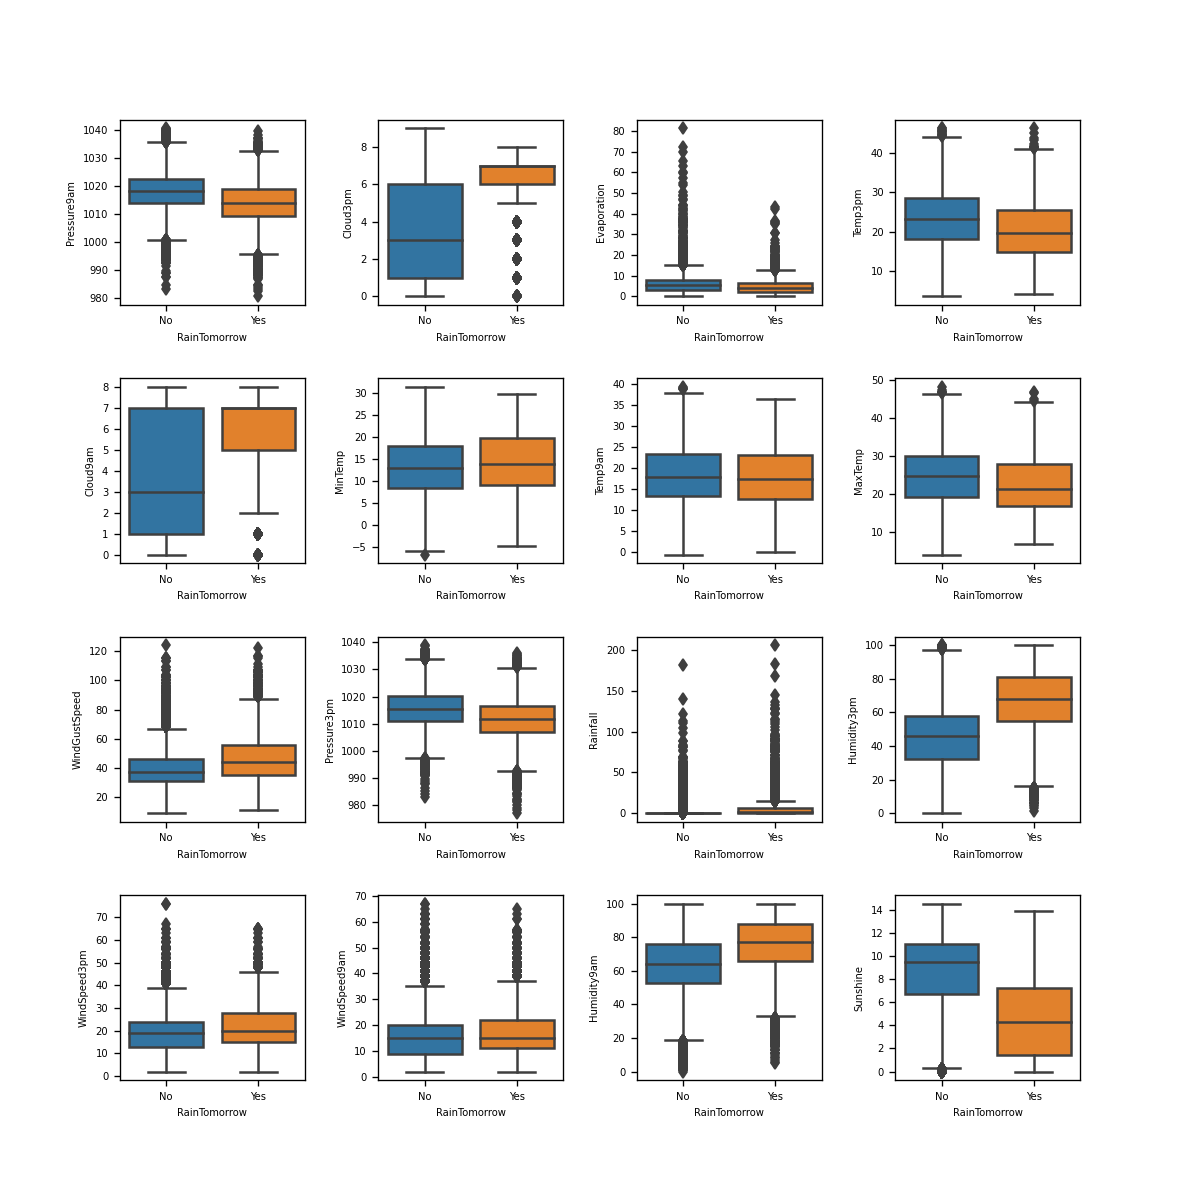

In [ ]:
features = list(set(data_na.columns) - set(['Date', 'Location', \
                                            'WindGustDir', 'WindDir9am', \
                                            'WindDir3pm', 'RainToday', \
                                            'RainTomorrow']))
                
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

for idx, feat in enumerate(features):
    sns.boxplot(x='RainTomorrow', y=feat, data=data_na, ax=axes[idx // 4, idx % 4])
    axes[idx // 4, idx % 4].set_xlabel('RainTomorrow')
    axes[idx // 4, idx % 4].set_ylabel(feat);


Из полученных boxplot-ов можно сделать первичные предположения о корреляции некоторых признаков с целевой переменной. Например, дождь на следующий день по отношению к характеристикам на предыдущем чаще наблюдается:
* при меньшем числе солнечных часов (*sunshine*) 
* при низком объеме испарений
* при высоком уровне влажности
* при более высоком уровне облачности
* при более низком давлении
* при более низкой температуре во второй половине дня

Наличие дождя на следующий день слабо зависит от таких признаков, как:
* скорость ветра
* минимальная температура и ее значение в первой половине дня

Проанализируем булевы признаки:

RainTomorrow  RainToday
0         False   0.152729
1          True   0.462139

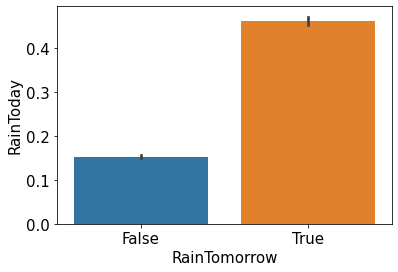

In [ ]:
to_bool = {'No' : False, 'Yes' : True}
data_na = data_na.replace({'RainToday': to_bool, 'RainTomorrow': to_bool})
data_na['RainToday'] = data_na['RainToday'].astype('bool')
data_na['RainTomorrow'] = data_na['RainTomorrow'].astype('bool')

sns.barplot(x='RainTomorrow', y='RainToday', data=data_na)
data_na.groupby('RainTomorrow', as_index=False).RainToday.mean()

Если сегодня дождь, то на следующий день он тоже будет с вероятностью в 46% <br><br><br>

Date  RainTomorrow
0     2007-11-01      1.000000
1     2007-11-02      1.000000
2     2007-11-03      1.000000
3     2007-11-04      1.000000
4     2007-11-05      0.000000
...          ...           ...
3411  2017-06-21      0.222222
3412  2017-06-22      0.000000
3413  2017-06-23      0.363636
3414  2017-06-24      0.000000
3415  2017-06-25      0.125000

[3416 rows x 2 columns]

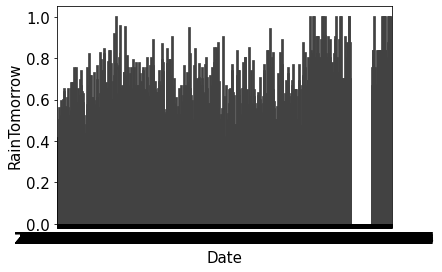

In [ ]:
sns.barplot(x='Date', y='RainTomorrow', data=data_na)
data_na.groupby('Date', as_index=False).RainTomorrow.mean()

Дата является довольно репрезентативным признаком, а потому ее необходимо оставить в числе этих признаков

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 [Text(0, 0, 'Cobar'),
  Text(1, 0, 'CoffsHarbour'),
  Text(2, 0, 'Moree'),
  Text(3, 0, 'NorfolkIsland'),
  Text(4, 0, 'Sydney'),
  Text(5, 0, 'SydneyAirport'),
  Text(6, 0, 'WaggaWagga'),
  Text(7, 0, 'Williamtown'),
  Text(8, 0, 'Canberra'),
  Text(9, 0, 'Sale'),
  Text(10, 0, 'MelbourneAirport'),
  Text(11, 0, 'Melbourne'),
  Text(12, 0, 'Mildura'),
  Text(13, 0, 'Portland'),
  Text(14, 0, 'Watsonia'),
  Text(15, 0, 'Brisbane'),
  Text(16, 0, 'Cairns'),
  Text(17, 0, 'Townsville'),
  Text(18, 0, 'MountGambier'),
  Text(19, 0, 'Nuriootpa'),
  Text(20, 0, 'Woomera'),
  Text(21, 0, 'PerthAirport'),
  Text(22, 0, 'Perth'),
  Text(23, 0, 'Hobart'),
  Text(24, 0, 'AliceSprings'),
  Text(25, 0, 'Darwin')])

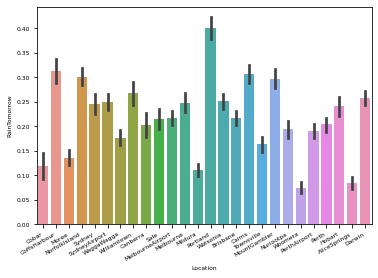

In [ ]:
sns.barplot(x='Location', y='RainTomorrow', data=data_na)
plt.xticks(rotation=30, ha='right')

В некоторых регионах дождь идет значительно чаще (например, в Portland или CoffsHarbour), в то время как в других почти не идет

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(x='WindGustDir', y='RainTomorrow', data=data_na, ax=axes[0])
sns.barplot(x='WindDir9am', y='RainTomorrow', data=data_na, ax=axes[1])
sns.barplot(x='WindDir3pm', y='RainTomorrow', data=data_na, ax=axes[2])

<AxesSubplot:xlabel='WindDir3pm', ylabel='RainTomorrow'>

Направление ветра слабо влияет на то, будет ли завтра в данном регионе дождь. Можно удалить эти признаки:

In [ ]:
del data['WindDir3pm'], data['WindDir9am'], data['WindGustDir']

---
### Часть 1. Первичная обработка данных

Заменим все недостающие количественные значения средними, категориальные  - *NotGiven*, а последние два признака приведем к булевому типу.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustSpeed  132923 non-null  float64
 8   WindSpeed9am   140845 non-null  float64
 9   WindSpeed3pm   139563 non-null  float64
 10  Humidity9am    140419 non-null  float64
 11  Humidity3pm    138583 non-null  float64
 12  Pressure9am    128179 non-null  float64
 13  Pressure3pm    128212 non-null  float64
 14  Cloud9am       88536 non-null   float64
 15  Cloud3pm       85099 non-null   float64
 16  Temp9am        141289 non-null  float64
 17  Temp3pm        139467 non-nul

Были произведены тесты при занулении некоторых ('Rainfall', 'Sunshine', 'Cloud9am' ...) признаков. Существенного различия в качестве получаемых моделей не обнаружено (тысячные доли для accuracy). Принято решение брать среднее значение по всем отстутствующим значениям.

In [ ]:
# Булевы признаки
to_bool = {'No' : False, 'Yes' : True}
data = data.replace({'RainToday': to_bool, 'RainTomorrow': to_bool})
data['RainToday'] = data['RainToday'].astype('bool')
data['RainTomorrow'] = data['RainTomorrow'].astype('bool')

"""
data[pd.Index(['Rainfall', 'Sunshine', 'Cloud9am', 'Cloud3pm'])] = \
        data[pd.Index(['Rainfall', 'Sunshine', 'Cloud9am', 'Cloud3pm'])].fillna(0)
data['RainToday'] = data['RainToday'].fillna(False)
"""

# Количественные признаки
numeric_data = data.select_dtypes([np.number])
numeric_data_col = numeric_data.columns
data[numeric_data_col] = \
                data[numeric_data_col].fillna(numeric_data.mean())

# Категориальные признаки
categorical_data = data.select_dtypes('object')
categorical_data_col = categorical_data.columns
data[categorical_data_col] = \
                data[categorical_data_col].fillna('NotGiven')

Разделим датасет на сборки для обучения (75%) и тестирования(15%)

In [ ]:
from sklearn.model_selection import train_test_split

x = data.drop(columns=["RainTomorrow"])
y = data.RainTomorrow
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.15, random_state=5)

---
### Часть 2. Логистическая регрессия Sklearn

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
def draw_confusion_matrix(y_test, y_pred):
    plt.rcParams.update({'font.size': 15})
    f, ax = plt.subplots(figsize=(10, 7))
    matrix = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(matrix, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_data_col),
    ('scaling', StandardScaler(), numeric_data_col)
])

log_reg_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

In [ ]:
accuracy = []
max_mean, best_c = 0, 0

for i in np.logspace(-3, 5, 60):
    
    log_reg_pipeline.set_params(regression__C = i)
    model = log_reg_pipeline.fit(x_train, y_train)
    mean = np.mean(model.predict(x_test) == y_test).round(3)
    accuracy.append(mean) 
    
    if mean > max_mean:
        max_mean = mean
        best_c = i

In [ ]:
print("Best C: ", best_c)
print("Best accuracy: ", max(accuracy))
plt.plot(np.logspace(-3, 5, 60), accuracy)
plt.grid()

Best C:  0.5150678076168121
Best accuracy:  0.852


              precision    recall  f1-score   support

       False       0.87      0.94      0.91     16530
        True       0.73      0.54      0.62      4799

    accuracy                           0.85     21329
   macro avg       0.80      0.74      0.76     21329
weighted avg       0.84      0.85      0.84     21329

Time:  1.0173734449999756  --  0.026094965996890096


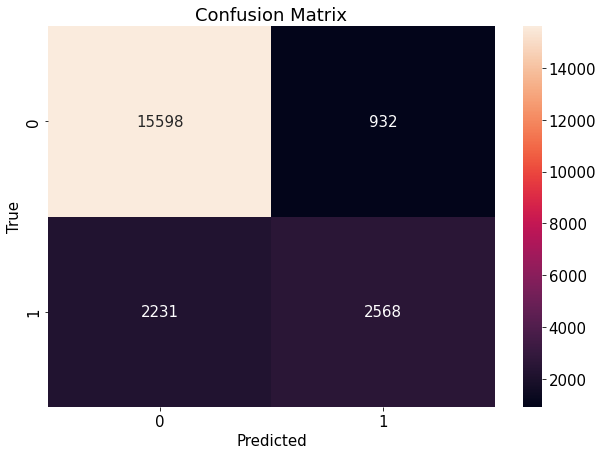

In [ ]:
log_reg_pipeline.set_params(regression__C = best_c)

start = time.process_time()
model = log_reg_pipeline.fit(x_train, y_train)
learning_time = time.process_time() - start

start = time.process_time()
y_pred = model.predict(x_test)
predict_time = time.process_time() - start

print(classification_report(y_test, y_pred))
draw_confusion_matrix(y_test, y_pred)
print("Time: ", learning_time, " -- ", predict_time)

**Вывод:**

Таким образом, полученная логистическая регрессия ошибается в 14.8% случаях. Это значительно лучше, чем допускать, что завтра по умолчанию дождя нет (тогда она будет ошибаться в 22.4% (см. первичный анализ данных)). Ее обучение занимает чуть больше 1 сек, предсказание на основе обученной модели - сотые доли секунды

---
### Часть 3. Метод ближайших соседей

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neighbors_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', KNeighborsClassifier(weights='distance', n_jobs=-1))
])

In [ ]:
# ЛУЧШЕ НЕ ПЕРЕЗАПУСКАТЬ! ЗАНИМАЕТ МИЛЛИОН ЛЕТ (около 15 мин на 6 ядрах)
accuracy_neighbors = []
max_mean_n, best_n = 0, 0

for n_neighbors in tqdm.tqdm(range(1, 25, 2)):
    
    neighbors_pipeline.set_params(regression__n_neighbors = n_neighbors)
    model = neighbors_pipeline.fit(x_train, y_train)
    mean = np.mean(model.predict(x_test) == y_test).round(3)
    accuracy_neighbors.append(mean)
    
    if mean > max_mean_n:
        max_mean_n = mean
        best_n = n_neighbors

100%|█████████████████████████████████████████████████████████████████| 12/12 [15:31<00:00, 77.59s/it]


Best number of neighbors:  19
Best accuracy:  0.852


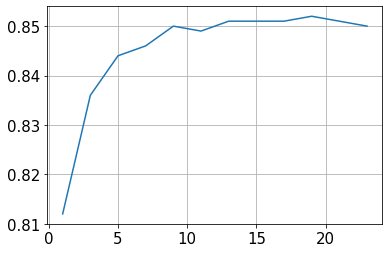

In [ ]:
print("Best number of neighbors: ", best_n)
print("Best accuracy: ", max_mean)
plt.plot(range(1, 25, 2), accuracy_neighbors)
plt.grid()

              precision    recall  f1-score   support

       False       0.86      0.96      0.91     16530
        True       0.77      0.48      0.59      4799

    accuracy                           0.85     21329
   macro avg       0.82      0.72      0.75     21329
weighted avg       0.84      0.85      0.84     21329

Time:  0.1408056049986044  --  242.02030257499973


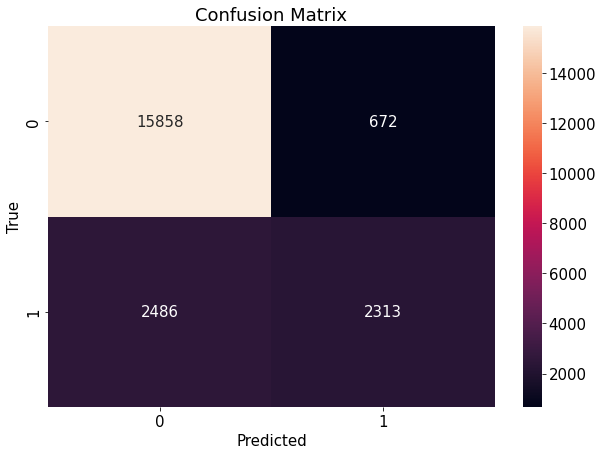

In [ ]:
neighbors_pipeline.set_params(regression__n_neighbors = 19)

start = time.process_time()
model = neighbors_pipeline.fit(x_train, y_train)
learning_time = time.process_time() - start

start = time.process_time()
y_pred = model.predict(x_test)
predict_time = time.process_time() - start

print(classification_report(y_test, y_pred))
draw_confusion_matrix(y_test, y_pred)
print("Time: ", learning_time, " -- ", predict_time)

In [ ]:
neighbors_pipeline.set_params(regression__n_neighbors = 8, regression__algorithm = 'kd_tree',
                             regression__weights='uniform')

start = time.process_time()
model = neighbors_pipeline.fit(x_train, y_train)
learning_time = time.process_time() - start

start = time.process_time()
y_pred = model.predict(x_test)
predict_time = time.process_time() - start

print(classification_report(y_test, y_pred))
print("Time: ", learning_time, " -- ", predict_time)

              precision    recall  f1-score   support

       False       0.86      0.96      0.91     16530
        True       0.78      0.44      0.56      4799

    accuracy                           0.85     21329
   macro avg       0.82      0.70      0.74     21329
weighted avg       0.84      0.85      0.83     21329

Time:  0.23516524299702724  --  250.26528676700036


**Вывод:**

Таким образом, получившаяся модель ошибается во все тех же 14.8% случаях. Изменение алгоритма, функции определения весов, незначительное уменьшение числа соседей не дает ни улучшения качества модели, ни уменьшает время, требующееся на получение предсказания. Получение предсказания занимает существенное время (4 мин времени процессора для нашей небольшой выборки данных), что обусловлено необходимостью перебора довольно большого числа объектов тестовой выборки. 

Использование данного алгоритма машинного обучения неоптимально для решения предложенной задачи, т.к. занимает значительно больше времени, чем логистическая регрессия, при примерно таком же качестве модели.

---
### Часть 3. Байесовский классификатор

In [ ]:
import sklearn.naive_bayes as nb
from sklearn.base import TransformerMixin

In [ ]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()
    
nb_column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_data_col),
    ('scaling', MinMaxScaler(), numeric_data_col)
])

In [ ]:
nb_gaussian_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', nb_column_transformer),
    ('to_dense', DenseTransformer()), 
    ('regression', nb.GaussianNB())
])

nb_multi_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', nb_column_transformer),
    ('regression', nb.MultinomialNB())
])

nb_bernoulli_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', nb_column_transformer),
    ('regression', nb.BernoulliNB())
])

nb_categor_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', nb_column_transformer),
    ('to_dense', DenseTransformer()), 
    ('regression', nb.CategoricalNB ())
])

nb_pipelines = [nb_gaussian_pipeline, nb_multi_pipeline, \
                    nb_bernoulli_pipeline, nb_categor_pipeline]

In [ ]:
df_rows = ['Accuracy', 'Time']
df_columns = ['GaussianNB', 'MultinomialNB', 'BernoulliNB', 'CategoricalNB']

df_values = np.zeros((2, 4))
for i in tqdm.tqdm(range(4)):
    
    start = time.process_time()
    model = nb_pipelines[i].fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    df_values[1, i] = time.process_time() - start
    df_values[0, i] = accuracy_score(y_test, y_pred)
    
pd.DataFrame(df_values, df_rows, df_columns)

100%|███████████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.41s/it]


GaussianNB  MultinomialNB  BernoulliNB  CategoricalNB
Accuracy    0.426133       0.794880     0.791505       0.781049
Time       11.141081       0.168158     0.188509      13.901309

Со стандартными гиперпараметрами из наивных байесовских алгоритмов наиболее точными и быстрыми являются MultinominalNB и BernoulliNB. Их мы и будем исследовать

GaussianNB можно не исследовать в связи с отсутсвием гиперпараметров, которые можно было бы оптимизировать, и ее крайней неэффективностью на тестовых данных. CategoricalNB также нам не походит, так как эта модель предполагает, что у кажого признака есть своя собственная категорилаьная принадлежность, что неверно в нашем случае

In [ ]:
nb_accuracy = []
max_nb_mean, best_alpha = 0, 0

for i in np.logspace(-5, 2, 60):
    
    nb_multi_pipeline.set_params(regression__alpha = i)
    model = nb_multi_pipeline.fit(x_train, y_train)
    mean = np.mean(model.predict(x_test) == y_test).round(3)
    nb_accuracy.append(mean) 
    
    if mean >= max_nb_mean:
        max_nb_mean = mean
        best_alpha = i

In [ ]:
print("Best alpha: ", best_alpha)
print("Best accuracy: ", max_nb_mean)
plt.plot(np.logspace(-3, 2, 60), nb_accuracy)
plt.grid()

Best alpha:  1.2638482029342972
Best accuracy:  0.795


              precision    recall  f1-score   support

       False       0.80      0.97      0.88     16530
        True       0.66      0.19      0.29      4799

    accuracy                           0.80     21329
   macro avg       0.73      0.58      0.59     21329
weighted avg       0.77      0.80      0.75     21329

Time:  0.14071665500159725  --  0.026830374001292512


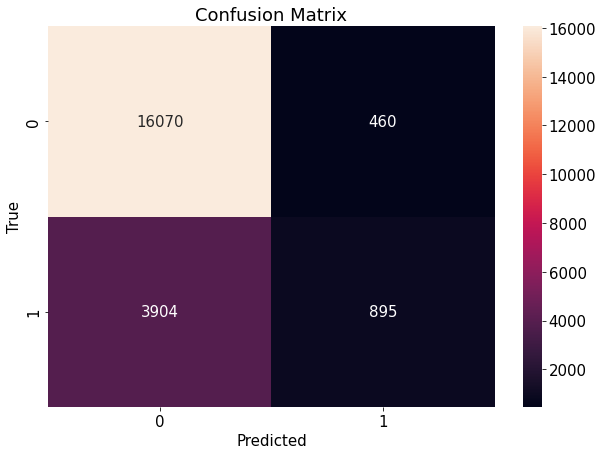

In [ ]:
nb_multi_pipeline.set_params(regression__alpha = best_alpha)
start = time.process_time()
model = nb_multi_pipeline.fit(x_train, y_train)
learning_time = time.process_time() - start

start = time.process_time()
y_pred = model.predict(x_test)
predict_time = time.process_time() - start

print(classification_report(y_test, y_pred))
draw_confusion_matrix(y_test, y_pred)
print("Time: ", learning_time, " -- ", predict_time)

In [ ]:
nb_accuracy = []
max_nbb_mean, bern_best_alpha = 0, 0

for i in np.logspace(-5, 2, 60):
    
    nb_bernoulli_pipeline.set_params(regression__alpha = i, regression__binarize=0.5)
    model = nb_bernoulli_pipeline.fit(x_train, y_train)
    mean = np.mean(model.predict(x_test) == y_test).round(3)
    nb_accuracy.append(mean) 
    
    if mean > max_nbb_mean:
        max_nbb_mean = mean
        bern_best_alpha = i

In [ ]:
print("Best alpha: ", bern_best_alpha)
print("Best accuracy: ", max_nbb_mean)
plt.plot(np.logspace(-3, 2, 60), nb_accuracy)
plt.grid()

Best alpha:  25.514065200312874
Best accuracy:  0.799


In [ ]:
nb_bernoulli_pipeline.set_params(regression__alpha = best_alpha)
start = time.process_time()
model = nb_bernoulli_pipeline.fit(x_train, y_train)
learning_time = time.process_time() - start

start = time.process_time()
y_pred = model.predict(x_test)
predict_time = time.process_time() - start

print(classification_report(y_test, y_pred))
draw_confusion_matrix(y_test, y_pred)
print("Time: ", learning_time, " -- ", predict_time)

              precision    recall  f1-score   support

       False       0.87      0.85      0.86     16530
        True       0.52      0.57      0.54      4799

    accuracy                           0.79     21329
   macro avg       0.70      0.71      0.70     21329
weighted avg       0.79      0.79      0.79     21329

Time:  0.15413967200220213  --  0.029083949000778375


**Вывод:**

Обе реализации наивного байесовского алгоритма оказываются лишь немногим лучше предположения, что априори дождя завтра нет. Их неэффективность объясняется тем, что они подходят для дискретных данных, каковыми наши данные не являются. Использование логистической регрессии предпочтительней

---
### Часть 4. Реализация логистической регрессии
__Логистическая регрессия__

$$p(y|x) = a(x, \theta) = \sigma(\langle x, \theta \rangle) = \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}$$

In [ ]:
theta = np.array([1, 2, 3])

X =  np.array([[ 1,  1, 1],
               [-1, -2, 1],
               [-1, -2, 2],
               [-2, -2, -3]
              ])

y_try = np.array([1, 1, 0, 0])

In [ ]:
def probability(theta, X):
    # MY CODE:
    result = 1 / (1 + np.exp(-X.dot(theta)))
    return result

prob = probability(theta, X)

assert type(prob) == np.ndarray, 'Возвращается неверный тип'
assert prob.shape == (X.shape[0],), 'Неверный размер массива'
assert (prob.round(3) == [0.998, 0.119, 0.731, 0.]).all(), 'Функция считается неверно'

Функция предсказания метки класса, получает на вход вероятности принадлежности к классу 1 и выдает метки классов $y \in \{0, 1\}$

In [ ]:
def binary_class_prediction(theta, X, threshold =.5):
    prob =  probability(theta, X)
    # MY CODE:
    result = np.where(prob > threshold, 1, 0)
    return result

y_pred = binary_class_prediction(theta, X)


assert type(y_pred) == np.ndarray, 'Возвращается неверный тип'
assert y_pred.shape == (X.shape[0],), 'Неверный размер массива'
assert min(y_pred) == 0, 'Функция считается неверно'
assert max(y_pred) == 1, 'Функция считается неверно'

__Функционал качества логистической регрессии__

Запишем правдободовие выборки для меток класса $y \in \{+1, -1\}$ 

$$Likelihood(a, X^\ell) = \prod_{i = 1}^{\ell} a(x_i,\theta)^{[y_i = +1]} (1 - a(x_i, \theta))^{[y_i = -1]} → \operatorname*{max}_{\theta}$$ 

Прологарифмируем правдоподобие выборки и перейдем к задаче минимизации:

$$Q(a, X^\ell) =     -\sum_{i = 1}^{\ell} 
        [y_i = +1] \log a(x_i, \theta)
        +
        [y_i = -1] \log (1 - a(x_i, \theta)) \to \operatorname*{min}_{\theta}$$ 
        
Подставим $a(x, \theta)$ в функцинал качества:

$$ Q(a, X^\ell) = -\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{\exp(-\langle \theta, x_i \rangle)}{1 + \exp(-\langle \theta, x_i \rangle)}
\right)
=\\
=
-\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{1}{1 + \exp(\langle \theta, x_i \rangle)}
\right)
=\\
=
\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) $$
    

Итоговый оптимизируемый функционал качества (logloss), записанный для меток классов $y \in \{+1, -1\}$ и усредненный по выборке

$$Q(a, X^\ell) = \frac{1}{\ell}\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) \to \operatorname*{min}_{\theta}$$

Реализуем его в функции logloss:

In [ ]:
def logloss(theta, X, y): 
    # MY CODE:
    y_for_formula = np.where(y == 0, -1, 1)
    result = np.mean(np.log(1 + np.exp((-y_for_formula)*X.dot(theta))))
    return result

In [ ]:
assert logloss(theta, X, y_try).round(3) == 0.861, 'Функция считается неверно'

__Алгоритм оптимизации функционала качества. Стохастический градиентный спуск__

<b>Вход: </b> Выборка $X^\ell$, темп обучения $h$

<b>Выход: </b> оптимальный вектор весов $\theta$

1.  Инициализировать веса $\theta$
2.  Инициализировать оценку функционала качества: $Q(a, X^\ell)$
3.  <b>Повторять</b>: 

    Выбрать случайным образом подвыборку объектов $X^{batch} =\{x_1, \dots,x_n \}$ из $X^{\ell}$
    
    Рассчитать градиент функционала качества: $\nabla Q(X^{batch}, \theta)$
    
    Обновить веса: $\theta := \theta - h\cdot \nabla Q(X^{batch}, \theta)$
       
    <b>Пока</b> значение $Q$ и/или веса $\theta$ не сойдутся   

Реализуем функцию рассчета градиента функционала качества

$$\frac{\partial Q(a, X^{batch}) }{\partial \theta_j}   = \frac{\partial \frac{1}{n}\sum_{i = 1}^{n}
    \log \left(
        1 + \exp(- y_i \langle \theta, x_i \rangle)
    \right)} {\partial \theta_j}  = \frac{1}{n}\sum_{i = 1}^{n}
     \frac {1}{
        1 + \exp(- y_i \langle \theta, x_i \rangle)} \cdot  \exp(- y_i \langle \theta, x_i \rangle) \cdot -y_i x_{ij}$$

Реализуйте рассчет градиента в матричном виде:

In [ ]:
def gradient(theta, X, y):
    # MY CODE:
    
    if not isinstance(X, np.ndarray) or \
            not isinstance(y, np.ndarray):
        raise TypeError
        
    result = np.mean(np.exp((-1) * y * X.dot(theta)) * X.T * (-1) * y / \
                     (1 + np.exp((-1 * y) * X.dot(theta))), axis=1)
    return result

assert gradient(theta, X, y_try).shape == theta.shape, 'Неверный размер массива'

Функция обучения уже реализована

In [ ]:
def fit(X, y, batch_size=10, h=0.05,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape
  
    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)
    
    errors = []
    
    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]
    
    # plt 
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        
        
    for _ in range(iters):  
        
        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)
        
        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'
        
        
        # Обновляем веса
        
        theta -= grad * h
        
        theta_history = np.vstack((theta_history, theta))
        
        # error
        loss = logloss(theta, X, y)
        errors.append(loss)
        
        if plot:
            ax1.clear()            
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')
            
            
            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('itarations')
            
            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('itarations')
            time.sleep(0.05)
            fig.canvas.draw()   
            
    return theta

In [ ]:
X, y_try = make_classification(n_samples=2000)

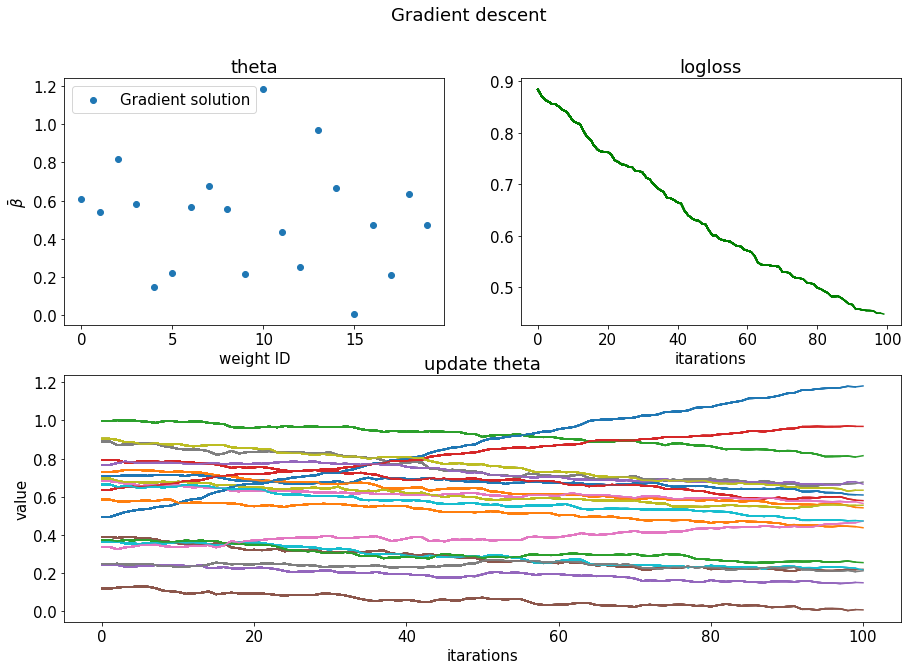

In [ ]:
optimal_theta = fit(X, y_try)

In [ ]:
y_pred = binary_class_prediction(optimal_theta, X)
print(classification_report(y_try, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1002
           1       0.79      0.80      0.80       998

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000



**Для наших данных:**

In [ ]:
from scipy.sparse.csr import csr_matrix
from sklearn.base import BaseEstimator, ClassifierMixin

class Custom_Log_Regression(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_size=10, h=0.05,  iters=100, plot=True):
        self.batch_size = batch_size
        self.h = h
        self.iters = iters
        self.plot = plot
    
    def get_params(self, deep=True):
        return {'batch_size' : self.batch_size, 'h' : self.h, 'iters' : self.iters, \
                        'plot' : self.plot}
        
    def set_params(self, **params):
        for parameter, value in params.items():
            setattr(self, parameter, value)
        return self
                  
    def fit(self, X, y):
        self.theta = fit(X, y, self.batch_size, self.h, self.iters, self.plot)
        
    def predict(self, X):
        return binary_class_prediction(self.theta, X)
    
    
class ToArrayTransformer(TransformerMixin):
    
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        if not isinstance(X, csr_matrix):
            raise TypeError
            
        return X.toarray()
    
    
custom_log_reg_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('to_array', ToArrayTransformer()),
    ('regression', Custom_Log_Regression())
])

In [ ]:
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.15, shuffle=False)

y_train, y_test = np.array(y_train, dtype=np.int8), np.array(y_test, dtype=np.int8)

Запуск со стандартными гиперпараметрами:

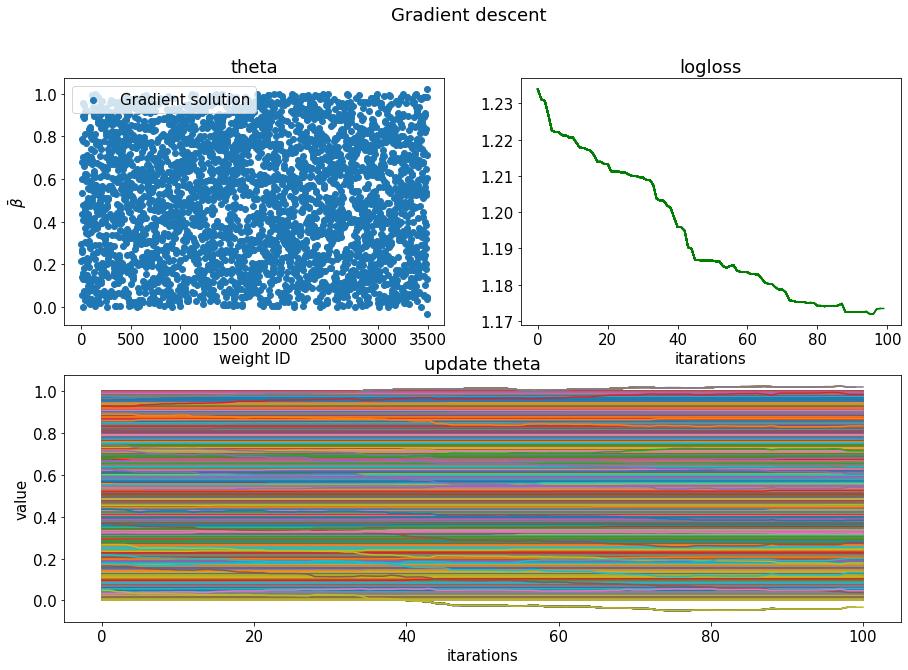

In [ ]:
# КРАЙНЕ НЕ РЕКОМЕНДУЕТСЯ ПЕРЕЗАПУСКАТЬ! (около 15 мин)
# ТЕПЛОВАЯ СМЕРТЬ ВСЕЛЕННОЙ НАСТУПИТ РАНЬШЕ, ЧЕМ ВЫПОЛНИТСЯ ЭТА ЯЧЕЙКА)

start = time.process_time()
model = custom_log_reg_pipeline.fit(x_train, y_train)
learning_time = time.process_time() - start

start = time.process_time()
y_pred = model.predict(x_test)
predict_time = time.process_time() - start

In [ ]:
print(classification_report(y_test, y_pred))
draw_confusion_matrix(y_test, y_pred)
print("Time: ", learning_time, " -- ", predict_time)

              precision    recall  f1-score   support

           0       0.91      0.58      0.71     16966
           1       0.33      0.78      0.46      4363

    accuracy                           0.62     21329
   macro avg       0.62      0.68      0.59     21329
weighted avg       0.79      0.62      0.66     21329

Time:  1031.320977751002  --  0.15983579800013104


Оптимальные гиперпараметры по соотношению качество модели / время выполнения

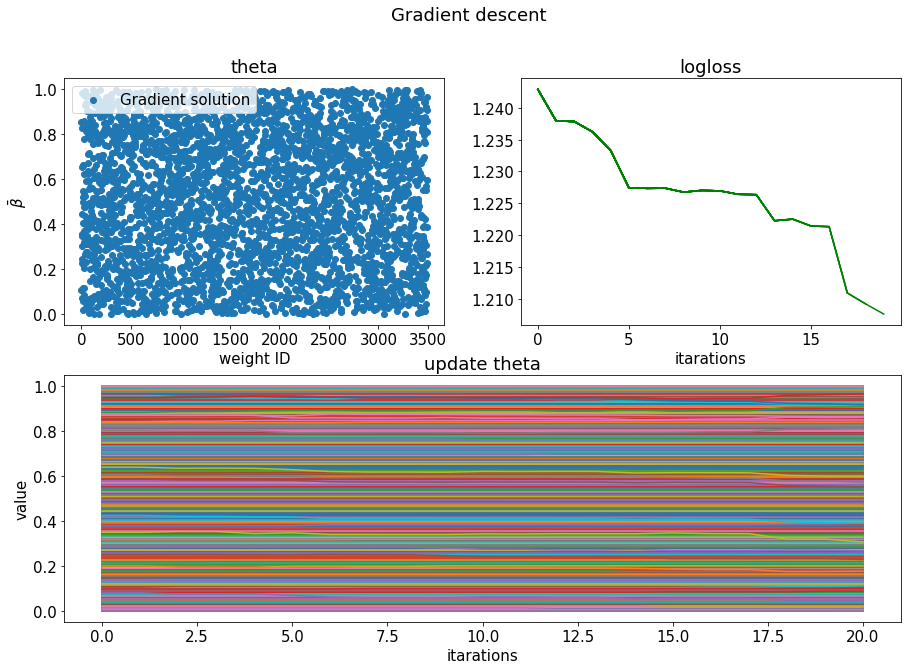

In [ ]:
garbage = custom_log_reg_pipeline.set_params(regression__iters = 20, regression__h = 0.1)
start = time.process_time()
model = custom_log_reg_pipeline.fit(x_train, y_train)
learning_time = time.process_time() - start

start = time.process_time()
y_pred = model.predict(x_test)
predict_time = time.process_time() - start

              precision    recall  f1-score   support

           0       0.91      0.57      0.70     16966
           1       0.32      0.78      0.45      4363

    accuracy                           0.61     21329
   macro avg       0.61      0.67      0.58     21329
weighted avg       0.79      0.61      0.65     21329

Time:  68.87187093299872  --  0.1431506039989472


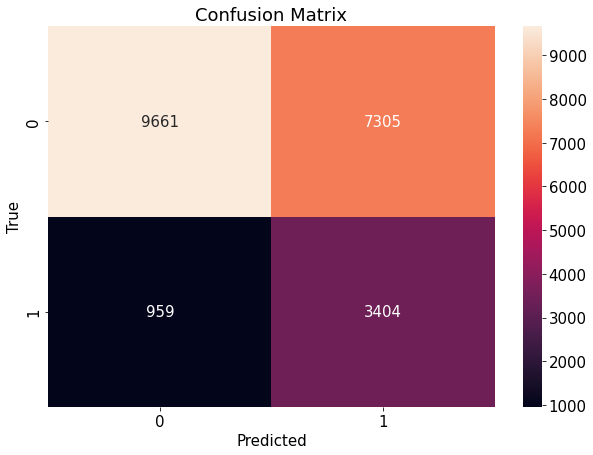

In [ ]:
print(classification_report(y_test, y_pred))
draw_confusion_matrix(y_test, y_pred)
print("Time: ", learning_time, " -- ", predict_time)

**Вывод:**

Таким образом, получившаяся модель ошибается в 37.6% случаях, что недопустимо для нашей задачи. Вполне возможно, что можно подобрать гиперпараметры, при которых алгоритм будет выдавать хотя бы 75 - 80% верных ответов, однако время его обучения слишком велико. Лучше использовать логистическую регрессию, представленную в библиотеке Sklearn